In [1]:
import tensorflow as tf
from src.dataset import dataset_tf, validation_tf, validate_on
from src.audio import to_mfccs_dataset, to_spectrogram_dataset
from src.model import get_seq_model, get_conv_model, callbacks, get_conv_model_mini
from src.plots import plot_history, plot_mfccs, plot_spectrograms
import numpy as np
LEARNING_RATE = 0.0001

0.90 - For proving that using pre-trained model works better

In [2]:
# train_ds, val_ds, label_names = dataset_tf("./dataset/sbcm_hive_1_train_copy", 0.30, 16)
# train_ds, val_ds, label_names = dataset_tf("./dataset/pitched_transformed_train", 0.50, 16)
train_ds, val_ds, label_names = dataset_tf("dataset/sbcm_hive_1_train", 0.80, 16)

Found 560 files belonging to 2 classes.
Using 112 files for training.
Using 448 files for validation.
label names: ['noqueen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (16, 4000)
Example label shape: (16,)


2024-03-28 23:51:37.547186: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-28 23:51:37.547214: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-28 23:51:37.547222: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-28 23:51:37.547259: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-28 23:51:37.547273: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


513 44100
Label: noqueen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)


In [3]:
train_mfccs_ds = to_mfccs_dataset(train_ds)
val_mfccs_ds = to_mfccs_dataset(val_ds)
train_spectrogram_ds = to_spectrogram_dataset(train_ds)
val_spectrogram_ds = to_spectrogram_dataset(val_ds)

513 44100
513 44100


# Train raw models

## Raw - MFCCs

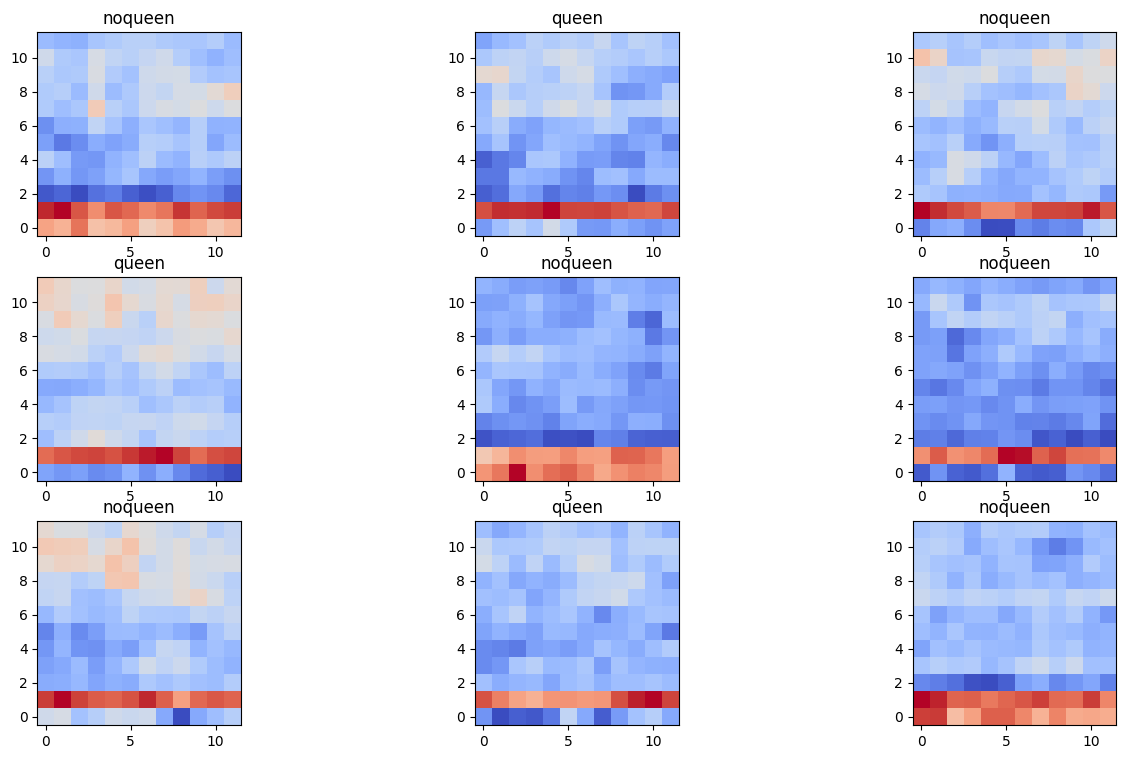

In [4]:
for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break

plot_mfccs(example_mfccs, example_mfccs_labels, label_names)

In [5]:
train_mfccs_ds = train_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
val_mfccs_ds = val_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))

for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break
input_shape = example_mfccs.shape[1:]
input_shape

TensorShape([12, 12, 1])

In [6]:
train_mfccs_ds = train_mfccs_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfccs_ds = val_mfccs_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Reinf:Raw] [MFCCs] Sequential Model

2024-03-28 23:51:39.017441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20
1/7 [===>..........................] - ETA: 2s - loss: 0.7237 - accuracy: 0.4375

2024-03-28 23:51:39.564946: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


7/7 [==============================] - 1s 80ms/step - loss: 0.6906 - accuracy: 0.5446 - val_loss: 0.6789 - val_accuracy: 0.6094
Epoch 2/20
7/7 [==============================] - 0s 34ms/step - loss: 0.5870 - accuracy: 0.6875 - val_loss: 0.6697 - val_accuracy: 0.5379
Epoch 3/20
7/7 [==============================] - 0s 34ms/step - loss: 0.5197 - accuracy: 0.7500 - val_loss: 0.6753 - val_accuracy: 0.5491
Epoch 4/20
7/7 [==============================] - 0s 35ms/step - loss: 0.4871 - accuracy: 0.7768 - val_loss: 0.6520 - val_accuracy: 0.5625
Epoch 5/20
7/7 [==============================] - 0s 35ms/step - loss: 0.4475 - accuracy: 0.8125 - val_loss: 0.6366 - val_accuracy: 0.5982
Epoch 6/20
7/7 [==============================] - 0s 35ms/step - loss: 0.4141 - accuracy: 0.8304 - val_loss: 0.6373 - val_accuracy: 0.5603
Epoch 7/20
7/7 [==============================] - 0s 38ms/step - loss: 0.3769 - accuracy: 0.8393 - val_loss: 0.6316 - val_accuracy: 0.5692


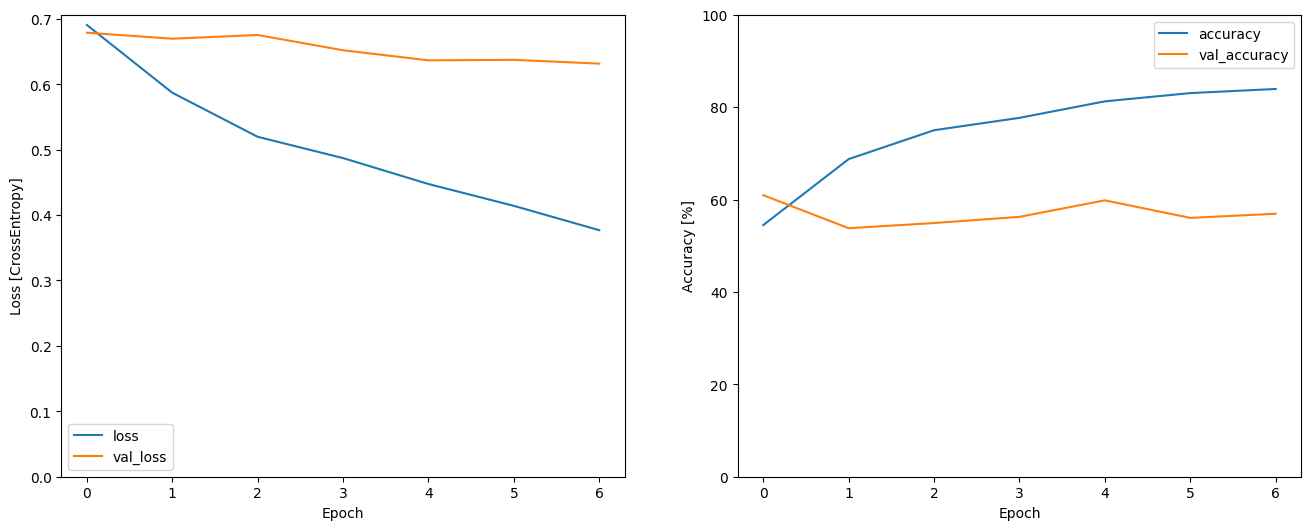

In [7]:
model_mfcc_seq = get_seq_model(input_shape, len(label_names), train_mfccs_ds)
model_mfcc_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_mfcc_seq = model_mfcc_seq.fit(
    train_mfccs_ds,
    validation_data=val_mfccs_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_seq)

### [Reinf:Raw] [MFCCs] Convolutional Model (mini)

Epoch 1/20
7/7 [==============================] - 0s 35ms/step - loss: 0.7041 - accuracy: 0.4911 - val_loss: 0.6958 - val_accuracy: 0.5379
Epoch 2/20
7/7 [==============================] - 0s 16ms/step - loss: 0.6878 - accuracy: 0.5089 - val_loss: 0.6923 - val_accuracy: 0.5089
Epoch 3/20
7/7 [==============================] - 0s 16ms/step - loss: 0.6797 - accuracy: 0.5446 - val_loss: 0.6914 - val_accuracy: 0.5402
Epoch 4/20
7/7 [==============================] - 0s 16ms/step - loss: 0.6736 - accuracy: 0.5893 - val_loss: 0.6891 - val_accuracy: 0.5424
Epoch 5/20
7/7 [==============================] - 0s 16ms/step - loss: 0.6687 - accuracy: 0.5893 - val_loss: 0.6870 - val_accuracy: 0.5402
Epoch 6/20
7/7 [==============================] - 0s 17ms/step - loss: 0.6642 - accuracy: 0.5982 - val_loss: 0.6854 - val_accuracy: 0.5357


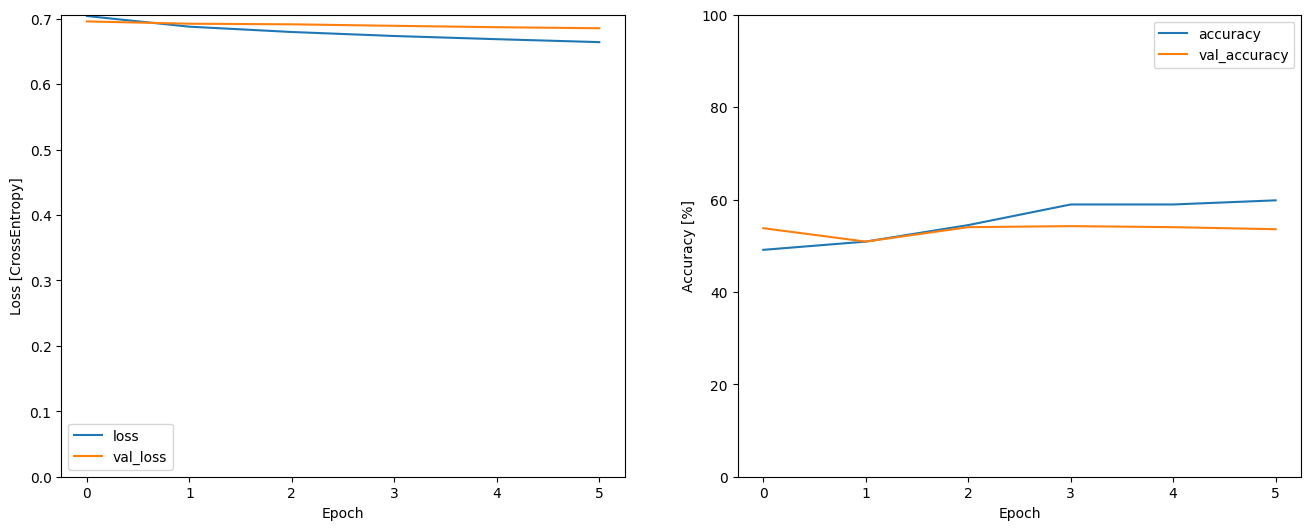

In [8]:
model_mfcc_conv = get_conv_model_mini(input_shape, len(label_names))
model_mfcc_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_mfcc_conv = model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_conv)

## Raw - Spectrograms

(118, 129, 1)


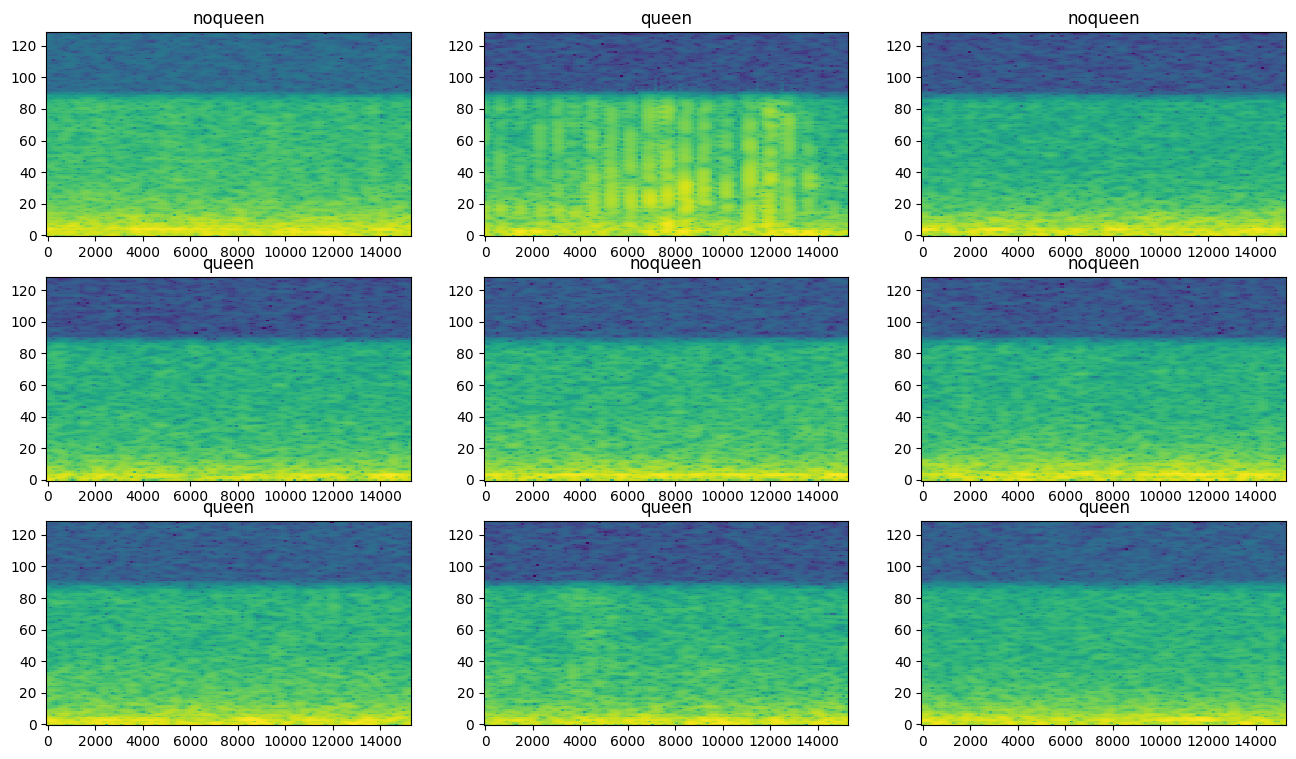

In [9]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
print(input_shape)
plot_spectrograms(example_spectrograms, example_spect_labels, label_names)

In [10]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Reinf:Raw] [Spec] Sequential model

Epoch 1/20
7/7 [==============================] - 1s 67ms/step - loss: 0.7098 - accuracy: 0.4911 - val_loss: 0.6964 - val_accuracy: 0.4821
Epoch 2/20
7/7 [==============================] - 0s 36ms/step - loss: 0.6738 - accuracy: 0.5714 - val_loss: 0.6914 - val_accuracy: 0.5156
Epoch 3/20
7/7 [==============================] - 0s 37ms/step - loss: 0.6514 - accuracy: 0.6429 - val_loss: 0.6956 - val_accuracy: 0.4799
Epoch 4/20
7/7 [==============================] - 0s 38ms/step - loss: 0.6162 - accuracy: 0.6964 - val_loss: 0.6924 - val_accuracy: 0.5112
Epoch 5/20
7/7 [==============================] - 0s 37ms/step - loss: 0.5996 - accuracy: 0.6875 - val_loss: 0.6936 - val_accuracy: 0.5379
Epoch 6/20
7/7 [==============================] - 0s 39ms/step - loss: 0.5784 - accuracy: 0.7500 - val_loss: 0.6948 - val_accuracy: 0.5246


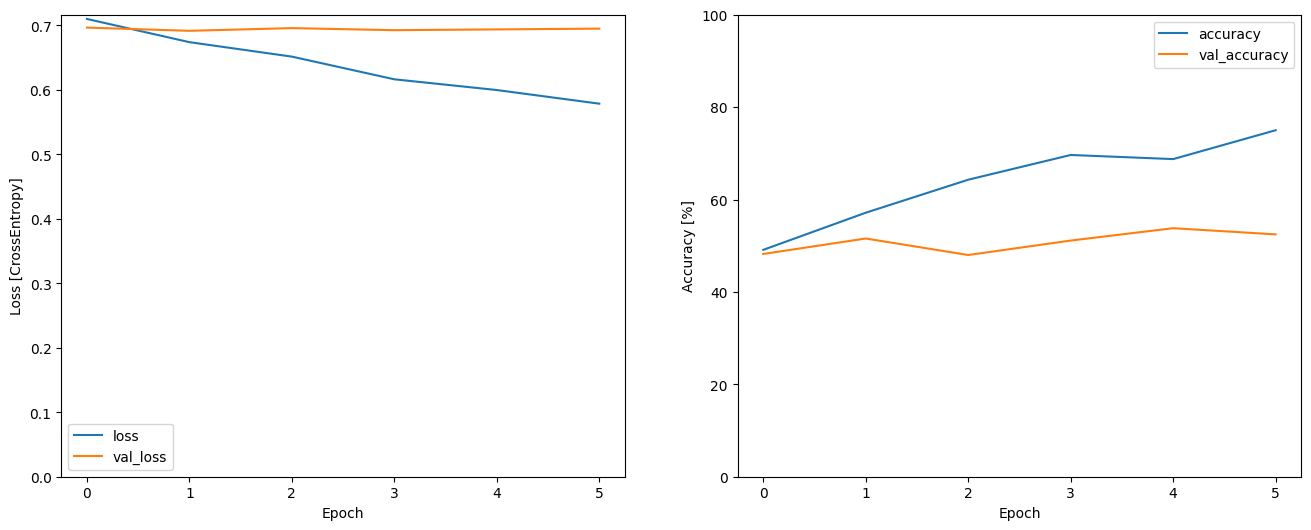

In [11]:
model_spec_seq = get_seq_model(input_shape, len(label_names), train_spectrogram_ds)
model_spec_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_spec_seq = model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_seq)

### [Reinf:Raw] [Spec] Convolutional model

Epoch 1/20
7/7 [==============================] - 1s 51ms/step - loss: 0.7009 - accuracy: 0.5982 - val_loss: 0.6977 - val_accuracy: 0.5045
Epoch 2/20
7/7 [==============================] - 0s 31ms/step - loss: 0.6885 - accuracy: 0.4732 - val_loss: 0.7082 - val_accuracy: 0.5045
Epoch 3/20
7/7 [==============================] - 0s 36ms/step - loss: 0.6617 - accuracy: 0.6161 - val_loss: 0.6977 - val_accuracy: 0.5268
Epoch 4/20
7/7 [==============================] - 0s 27ms/step - loss: 0.6470 - accuracy: 0.6875 - val_loss: 0.6964 - val_accuracy: 0.5223
Epoch 5/20
7/7 [==============================] - 0s 28ms/step - loss: 0.6349 - accuracy: 0.7857 - val_loss: 0.6945 - val_accuracy: 0.5513
Epoch 6/20
7/7 [==============================] - 0s 35ms/step - loss: 0.6265 - accuracy: 0.6964 - val_loss: 0.6949 - val_accuracy: 0.5223
Epoch 7/20
7/7 [==============================] - 0s 27ms/step - loss: 0.6084 - accuracy: 0.8036 - val_loss: 0.6946 - val_accuracy: 0.5558


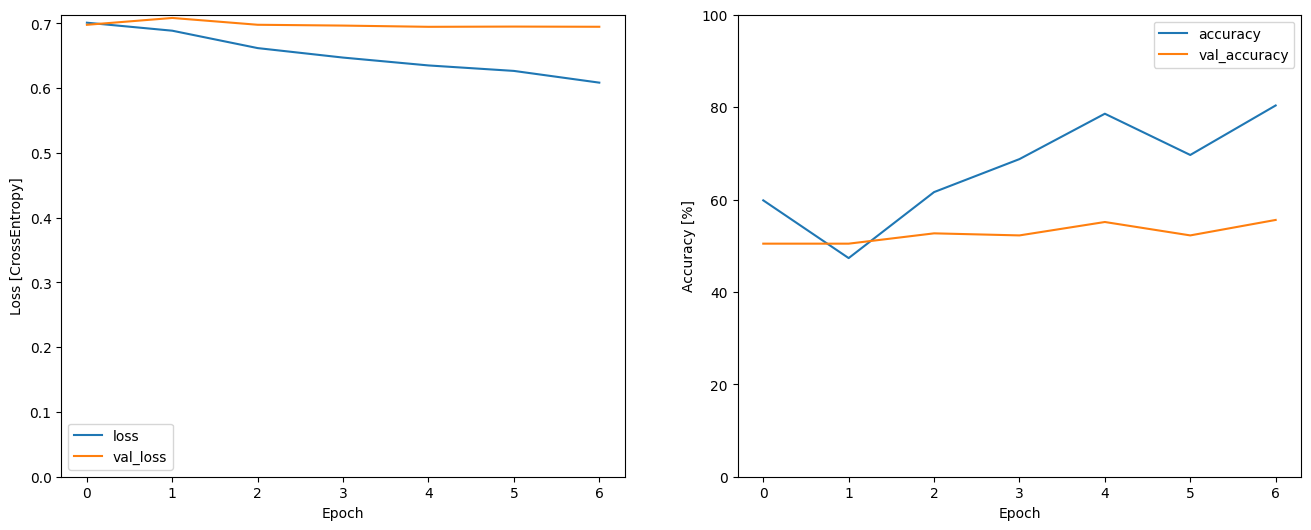

In [12]:
model_spec_conv = get_conv_model(input_shape, len(label_names))
model_spec_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_spec_conv = model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_conv)

# Pre-trained models

In [13]:
trained_model_mfcc_seq = tf.keras.models.load_model("models/mfcc_seq.h5")
trained_model_mfcc_conv = tf.keras.models.load_model("models/mfcc_conv_mini.h5")
trained_model_spec_seq = tf.keras.models.load_model("models/spec_seq.h5")
trained_model_spec_conv = tf.keras.models.load_model("models/spec_conv.h5")

In [14]:
results = trained_model_mfcc_seq.evaluate(val_mfccs_ds)
print(f"MFCC Seq: {results}")
results = trained_model_mfcc_conv.evaluate(val_mfccs_ds)
print(f"MFCC Conv: {results}")
results = trained_model_spec_seq.evaluate(val_spectrogram_ds)
print(f"Spec Seq: {results}")
results = trained_model_spec_conv.evaluate(val_spectrogram_ds)
print(f"Spec Conv: {results}")

28/28 [==============================] - 0s 6ms/step - loss: 7.7043 - accuracy: 0.5089
MFCC Seq: [7.704300880432129, 0.5089285969734192]
28/28 [==============================] - 0s 4ms/step - loss: 2.7846 - accuracy: 0.5089
MFCC Conv: [2.784597158432007, 0.5089285969734192]
28/28 [==============================] - 0s 7ms/step - loss: 2.4355 - accuracy: 0.5089
Spec Seq: [2.435533046722412, 0.5089285969734192]
28/28 [==============================] - 0s 4ms/step - loss: 4.3384 - accuracy: 0.5089
Spec Conv: [4.338391304016113, 0.5089285969734192]


### [Reinf] [MFCCs] Sequential model

Epoch 1/20
7/7 [==============================] - 1s 38ms/step - loss: 5.8408 - accuracy: 0.4643 - val_loss: 1.8383 - val_accuracy: 0.5089
Epoch 2/20
7/7 [==============================] - 0s 41ms/step - loss: 1.6835 - accuracy: 0.5357 - val_loss: 2.7083 - val_accuracy: 0.4933
Epoch 3/20
7/7 [==============================] - 0s 37ms/step - loss: 2.2897 - accuracy: 0.5625 - val_loss: 2.4200 - val_accuracy: 0.4933
Epoch 4/20
7/7 [==============================] - 0s 41ms/step - loss: 1.6312 - accuracy: 0.5536 - val_loss: 1.5086 - val_accuracy: 0.4955
Epoch 5/20
7/7 [==============================] - 0s 39ms/step - loss: 1.1011 - accuracy: 0.5357 - val_loss: 0.9602 - val_accuracy: 0.4531
Epoch 6/20
7/7 [==============================] - 0s 41ms/step - loss: 0.8296 - accuracy: 0.5804 - val_loss: 0.8060 - val_accuracy: 0.4442


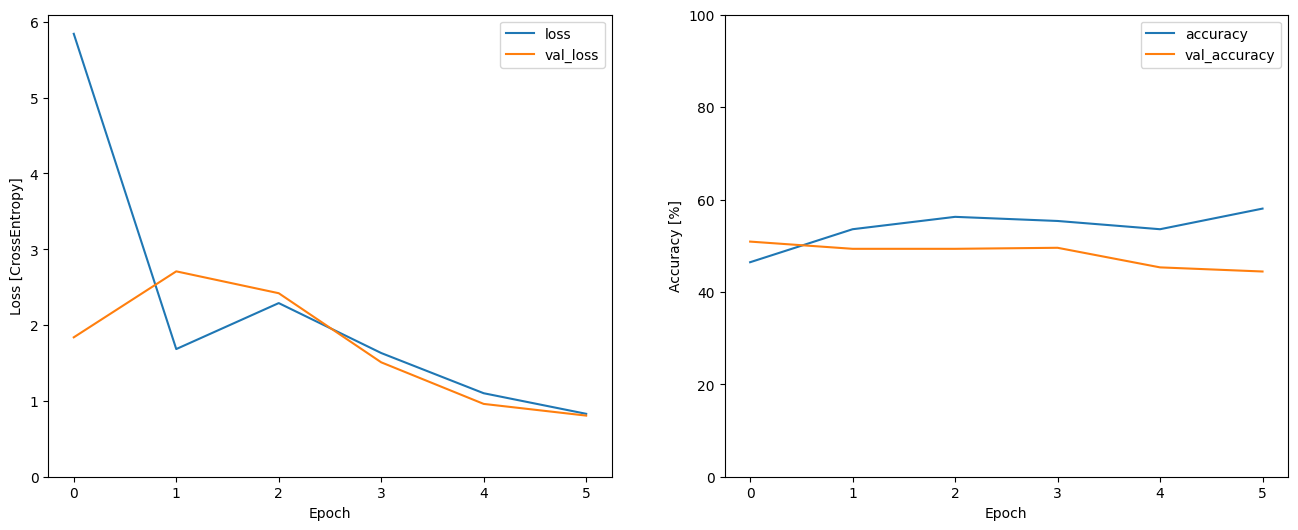

In [15]:
trained_history_mfcc_seq = trained_model_mfcc_seq.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_mfcc_seq)

### [Reinf] [MFCCs] Convolutional model (mini)

Epoch 1/20
7/7 [==============================] - 0s 18ms/step - loss: 2.5620 - accuracy: 0.4643 - val_loss: 1.7668 - val_accuracy: 0.5089
Epoch 2/20
7/7 [==============================] - 0s 17ms/step - loss: 1.2313 - accuracy: 0.4643 - val_loss: 0.7400 - val_accuracy: 0.6183
Epoch 3/20
7/7 [==============================] - 0s 18ms/step - loss: 0.7332 - accuracy: 0.5536 - val_loss: 0.9318 - val_accuracy: 0.4978
Epoch 4/20
7/7 [==============================] - 0s 16ms/step - loss: 0.8457 - accuracy: 0.5446 - val_loss: 0.8960 - val_accuracy: 0.4978
Epoch 5/20
7/7 [==============================] - 0s 16ms/step - loss: 0.7255 - accuracy: 0.6071 - val_loss: 0.7116 - val_accuracy: 0.4955
Epoch 6/20
7/7 [==============================] - 0s 16ms/step - loss: 0.6341 - accuracy: 0.5714 - val_loss: 0.6701 - val_accuracy: 0.5826
Epoch 7/20
7/7 [==============================] - 0s 16ms/step - loss: 0.6314 - accuracy: 0.6339 - val_loss: 0.6706 - val_accuracy: 0.6250
Epoch 8/20
7/7 [===========

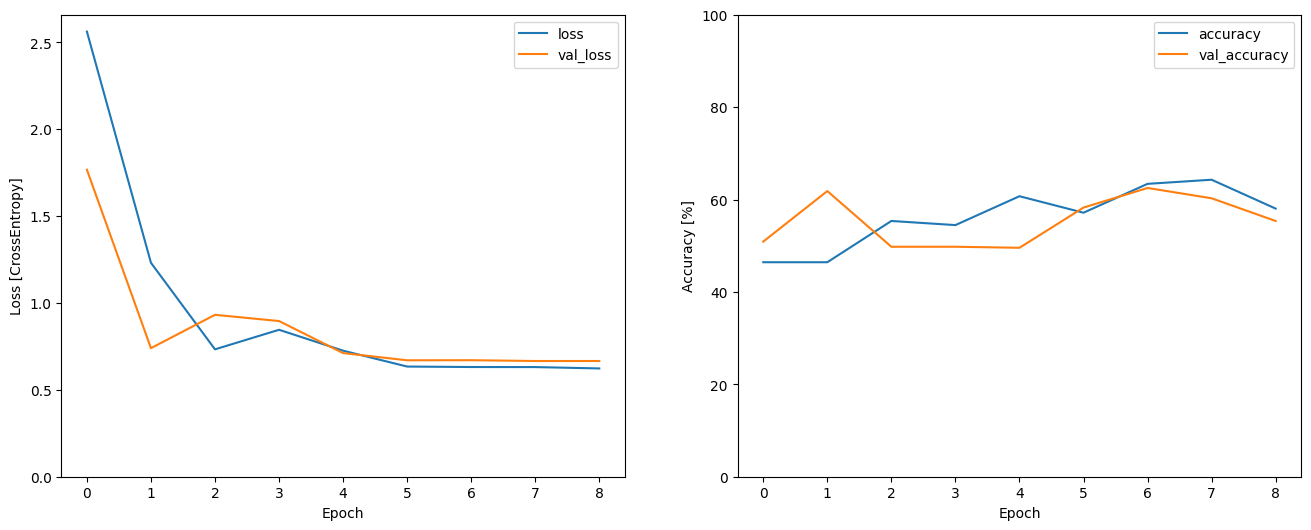

In [16]:
trained_history_mfcc_conv = trained_model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_mfcc_conv)

### [Reinf] [Spec] Sequential model

Epoch 1/20
7/7 [==============================] - 1s 38ms/step - loss: 1.8263 - accuracy: 0.4018 - val_loss: 1.5082 - val_accuracy: 0.4821
Epoch 2/20
7/7 [==============================] - 0s 36ms/step - loss: 1.1853 - accuracy: 0.4554 - val_loss: 1.0802 - val_accuracy: 0.5268
Epoch 3/20
7/7 [==============================] - 0s 35ms/step - loss: 0.8709 - accuracy: 0.5714 - val_loss: 0.8714 - val_accuracy: 0.4509
Epoch 4/20
7/7 [==============================] - 0s 36ms/step - loss: 0.7475 - accuracy: 0.5893 - val_loss: 0.9380 - val_accuracy: 0.4196
Epoch 5/20
7/7 [==============================] - 0s 36ms/step - loss: 0.6664 - accuracy: 0.6339 - val_loss: 0.8495 - val_accuracy: 0.5045
Epoch 6/20
7/7 [==============================] - 0s 36ms/step - loss: 0.6169 - accuracy: 0.6875 - val_loss: 0.8518 - val_accuracy: 0.5357
Epoch 7/20
7/7 [==============================] - 0s 40ms/step - loss: 0.5804 - accuracy: 0.7054 - val_loss: 0.8286 - val_accuracy: 0.4688
Epoch 8/20
7/7 [===========

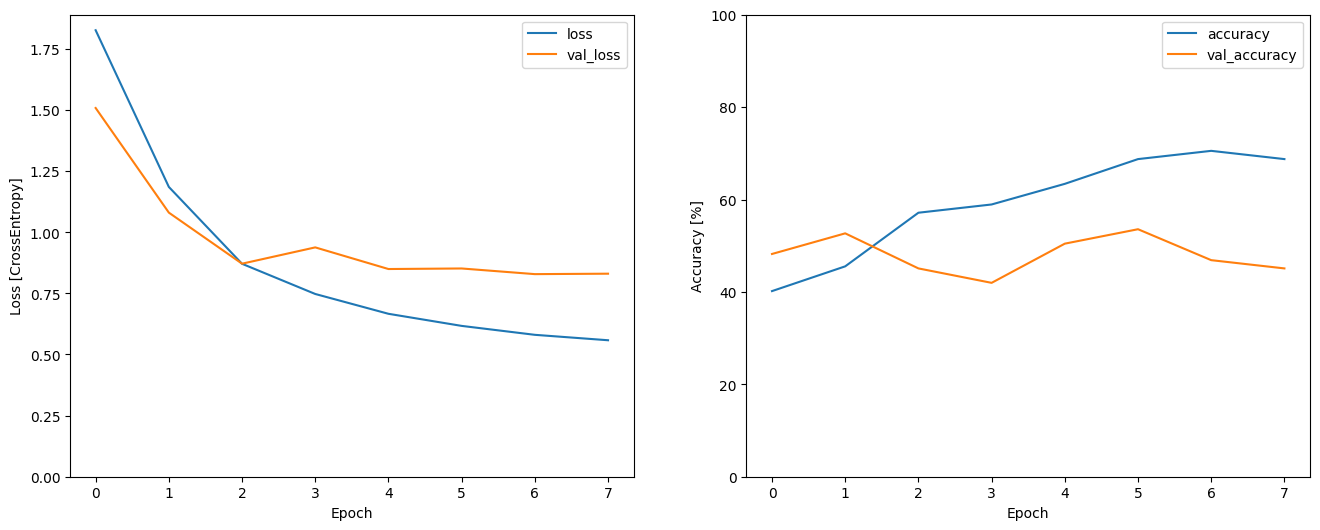

In [17]:
trained_history_spec_seq = trained_model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_spec_seq)

### [Reinf] [Spec] Convolutional model

Epoch 1/20
7/7 [==============================] - 0s 27ms/step - loss: 2.1351 - accuracy: 0.5179 - val_loss: 1.9962 - val_accuracy: 0.4933
Epoch 2/20
7/7 [==============================] - 0s 31ms/step - loss: 1.3527 - accuracy: 0.5268 - val_loss: 1.2305 - val_accuracy: 0.5067
Epoch 3/20
7/7 [==============================] - 0s 27ms/step - loss: 0.9134 - accuracy: 0.5357 - val_loss: 0.9650 - val_accuracy: 0.4621
Epoch 4/20
7/7 [==============================] - 0s 26ms/step - loss: 0.9855 - accuracy: 0.5446 - val_loss: 0.9870 - val_accuracy: 0.5112
Epoch 5/20
7/7 [==============================] - 0s 19ms/step - loss: 0.8600 - accuracy: 0.5179 - val_loss: 0.8259 - val_accuracy: 0.4799
Epoch 6/20
7/7 [==============================] - 0s 25ms/step - loss: 0.8097 - accuracy: 0.5625 - val_loss: 0.8300 - val_accuracy: 0.4665


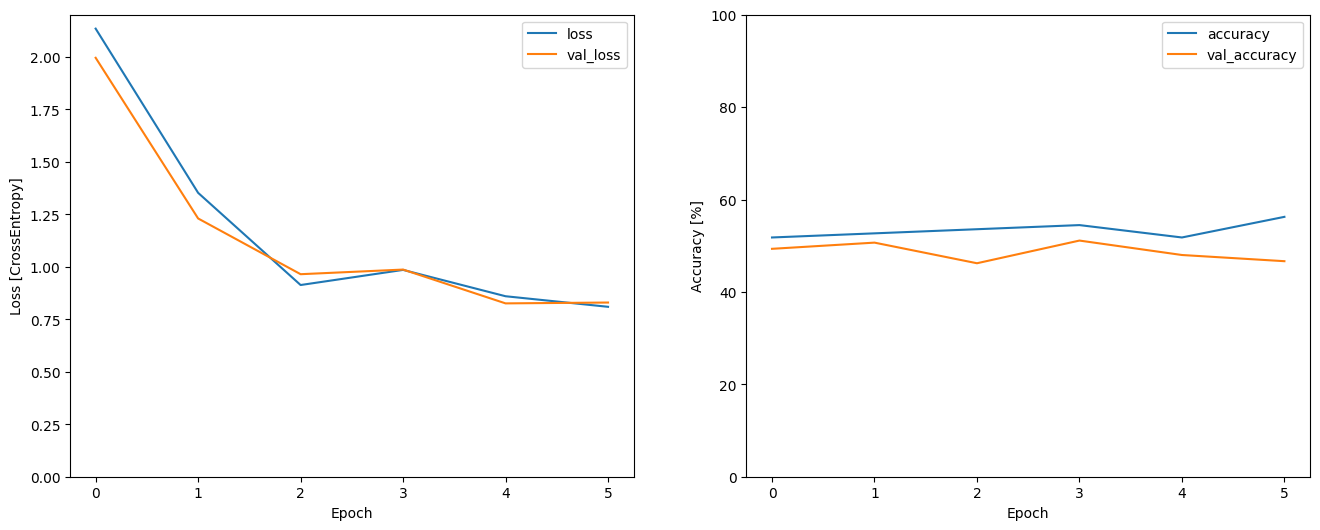

In [18]:
trained_history_spec_conv = trained_model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_spec_conv)

# Save models

In [19]:
trained_model_mfcc_seq.save('models/renf_mfcc_seq.h5')
trained_model_mfcc_conv.save('models/renf_mfcc_conv.h5')
trained_model_spec_seq.save('models/renf_spec_seq.h5')
trained_model_spec_conv.save('models/renf_spec_conv.h5')

/Users/lantain/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Summary

In [20]:
def history_to_summary(prefix: str, history):
    print(f"{prefix}:    Loss: {history.history['loss'][-1]:.2f}, Acc: {history.history['accuracy'][-1]:.2f}, VLoss: {history.history['val_loss'][-1]:.2f}, VAcc: {history.history['val_accuracy'][-1]:.2f}" )

print("=== RAW ===")
history_to_summary("MFCCs + Seq       ", history_mfcc_seq)
history_to_summary("MFCCs + Conv      ", history_mfcc_conv)
history_to_summary("Spectrogram + Seq ", history_spec_seq)
history_to_summary("Spectrogram + Conv", history_spec_conv)
print("")
print("=== TRAINED ===")
history_to_summary("Tr. MFCCs + Seq       ", trained_history_mfcc_seq)
history_to_summary("Tr. MFCCs + Conv      ", trained_history_mfcc_conv)
history_to_summary("Tr. Spectrogram + Seq ", trained_history_spec_seq)
history_to_summary("Tr. Spectrogram + Conv", trained_history_spec_conv)


=== RAW ===
MFCCs + Seq       :    Loss: 0.38, Acc: 0.84, VLoss: 0.63, VAcc: 0.57
MFCCs + Conv      :    Loss: 0.66, Acc: 0.60, VLoss: 0.69, VAcc: 0.54
Spectrogram + Seq :    Loss: 0.58, Acc: 0.75, VLoss: 0.69, VAcc: 0.52
Spectrogram + Conv:    Loss: 0.61, Acc: 0.80, VLoss: 0.69, VAcc: 0.56

=== TRAINED ===
Tr. MFCCs + Seq       :    Loss: 0.83, Acc: 0.58, VLoss: 0.81, VAcc: 0.44
Tr. MFCCs + Conv      :    Loss: 0.62, Acc: 0.58, VLoss: 0.67, VAcc: 0.55
Tr. Spectrogram + Seq :    Loss: 0.56, Acc: 0.69, VLoss: 0.83, VAcc: 0.45
Tr. Spectrogram + Conv:    Loss: 0.81, Acc: 0.56, VLoss: 0.83, VAcc: 0.47
